# Libraries

In [245]:
import ast
import math
import os
import gc

import cv2
from pathlib import Path

from PIL import Image, ImageSequence
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelextrema
# from skfda import FDataGrid
from numpy import unravel_index
import statistics
import heapq
import pandas as pd
from scipy.interpolate import interp1d

# import tensorflow as tf
# from tensorflow.keras import layers, models

import itertools

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.patches as patches

from scipy.optimize import least_squares

# Functions

## Smoothing

In [246]:
def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

In [247]:
def merge_peaks_by_distance(peaks, min_distance):
    merged_peaks = []
    i = 0
    while i < len(peaks) - 1:
        if abs(peaks[i] - peaks[i+1]) <= min_distance:
            merged_peak = (peaks[i] + peaks[i+1]) // 2
            merged_peaks.append(merged_peak)
            i += 2  
        else:
            merged_peaks.append(peaks[i])
            i += 1

    if i == len(peaks) - 1:
        merged_peaks.append(peaks[i])
    return merged_peaks


## Circle functions

In [248]:
def circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow):
    # Adjusted peak selection to use closest peaks around ccol
    closest_peak_x = min(peaks_x, key=lambda x: abs(x-ccol))
    closest_peak_y = min(peaks_y, key=lambda y: abs(y-crow))

    # Using peak indices to find distances to closest peaks
    # peak_index_x = peaks_x.tolist().index(closest_peak_x)
    # peak_index_y = peaks_y.tolist().index(closest_peak_y)
    peak_index_x=peaks_x.index(closest_peak_x)
    peak_index_y=peaks_y.index(closest_peak_y)

    if peak_index_x > 0:
        if len(peaks_x)==peak_index_x+1:
            peak_index_x-=1
        rl_x = ccol - peaks_x[peak_index_x - ring_index]
        rr_x = peaks_x[peak_index_x + ring_index] - ccol

    if peak_index_y > 0:
        if len(peaks_y)==peak_index_y+1:
            peak_index_y-=1
        ru_y = crow - peaks_y[peak_index_y - ring_index]
        rl_y = peaks_y[peak_index_y + ring_index] - crow


    return round((rl_x + rr_x + ru_y + rl_y) / 4., 5)

In [249]:
def circle_radius_fun3(peaks_x, peaks_y, ccol, crow):
    def residuals(params, x, y):
        xc, yc, r = params
        return np.sqrt((x - xc)**2 + (y - yc)**2) - r

    initial_guess = [ccol, crow, 1]
    result = least_squares(residuals, initial_guess, args=(peaks_x, peaks_y))
    xc, yc, r = result.x
    return r

In [250]:
def circle_radius_fun2(peaks_x, peaks_y, ring_index, ccol, crow):
    def residuals(params, x, y):
        xc, yc, r = params
        return np.sqrt((x - xc)**2 + (y - yc)**2) - r

    # Select the peaks based on the ring_index
    closest_peak_x = min(peaks_x, key=lambda x: abs(x - ccol))
    closest_peak_y = min(peaks_y, key=lambda y: abs(y - crow))

    peak_index_x = peaks_x.index(closest_peak_x)
    peak_index_y = peaks_y.index(closest_peak_y)

    if peak_index_x > 0:
        if len(peaks_x) == peak_index_x + 1:
            peak_index_x -= 1
        rl_x = ccol - peaks_x[peak_index_x - ring_index]
        rr_x = peaks_x[peak_index_x + ring_index] - ccol

    if peak_index_y > 0:
        if len(peaks_y) == peak_index_y + 1:
            peak_index_y -= 1
        ru_y = crow - peaks_y[peak_index_y - ring_index]
        rl_y = peaks_y[peak_index_y + ring_index] - crow

    # Use the selected peaks for circle fitting
    selected_peaks_x = peaks_x[peak_index_x - ring_index:peak_index_x + ring_index + 1]
    selected_peaks_y = peaks_y[peak_index_y - ring_index:peak_index_y + ring_index + 1]

    initial_guess = [ccol, crow, 34]
    result = least_squares(residuals, initial_guess, args=(selected_peaks_x, selected_peaks_y))
    xc, yc, r = result.x
    return r


In [251]:
def circle_change_limiter(circle_radius,prev_circle_radius,allowed_change,ring_index,peaks_x,peaks_y,ccol,crow):
    if prev_circle_radius is not None and circle_radius > prev_circle_radius * (1+allowed_change) and ring_index != 1:
        ring_index=ring_index-1
        # ccol=prev_ccol
        # crow=prev_crow
        print(f'{circle_radius} high')
        circle_radius=circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
    elif prev_circle_radius is not None and circle_radius < prev_circle_radius * (1-allowed_change):
        print(prev_circle_radius * 1-allowed_change)
        ring_index=ring_index+1
        # ccol=prev_ccol
        # crow=prev_crow
        print('low')
        circle_radius=circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
    return circle_radius,ring_index

In [252]:
def get_center_from_peaks(peaks, current_center):
    # print(f'peaks: {peaks}\ncurrentCenter: {current_center}')
    valid_peaks = [peak for peak in peaks if np.abs(peak - current_center) >= 10]
    left_peaks = np.array([peak for peak in valid_peaks if peak < current_center])
    right_peaks = np.array([peak for peak in valid_peaks if peak > current_center])

    if len(left_peaks) == 0 or len(right_peaks) == 0:
        return current_center, 0

    left_peak = left_peaks[-1] 
    right_peak = right_peaks[0] 

    refined_center = (left_peak + right_peak) / 2
    

    distance_between_peaks = np.abs(right_peak - left_peak)

    return refined_center, distance_between_peaks

In [253]:
def adaptive_movement_threshold(prev_ccol, prev_crow, ccol, crow, prev_movement, allowed_change=5):
    # movement
    if prev_ccol != None and prev_crow!= None:
        distance = np.linalg.norm([ccol - prev_ccol, crow - prev_crow])
        print(distance)
        
        # if the center moves in the video, increase allowance
        if distance > prev_movement:
            allowed_change = min(distance, allowed_change * 2)
        
        # Allow movement if it is within the allowed range
        if distance <= allowed_change:
            return ccol, crow, distance
        else:
            # Reject large shifts
            return prev_ccol, prev_crow, prev_movement
    else:
        return ccol,crow,prev_movement


In [254]:
def get_center_from_minimums(minimums, current_center,min_depth=0.25):
    valid_minimums = [minm for minm in minimums if np.abs(minm - current_center) >= 10]
    left_minimums = np.array([minm for minm in valid_minimums if minm < current_center])
    right_minimums = np.array([minm for minm in valid_minimums if minm > current_center])

    if len(left_minimums) == 0 or len(right_minimums) == 0:
        return current_center, 0

    left_minimum = left_minimums[-2] 
    right_minimum = right_minimums[1]  

    refined_center = (left_minimum + right_minimum) // 2

    distance_between_minimums = np.abs(right_minimum - left_minimum)

    return refined_center, distance_between_minimums


In [255]:
def draw_circle(image,ccol,crow,circle_radius):
    cross_length=10

    circle_img = cv2.circle(image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
    cv2.line(circle_img,(ccol - cross_length, crow), (ccol + cross_length, crow), (255, 255, 255), 1)
    cv2.line(circle_img, (ccol, crow - cross_length), (ccol, crow + cross_length), (255, 255, 255), 1)
    
    return circle_img

In [256]:
# def houghCircle(ccol,crow,radius,image):
#     # ccol -y, crow - x
#     print(f'{ccol} {crow} {radius}')
#     x, y, r = int(crow), int(ccol), int(radius)+20
    
#     x_start = max(0, x - r)
#     y_start = max(0, y - r)
#     roi = image[y_start:y_start + 2 * r, x_start:x_start + 2 * r]

#     circles = cv2.HoughCircles(roi, cv2.HOUGH_GRADIENT, dp=1.5, minDist=0.01,
#                             param1=10, param2=10, minRadius=0, maxRadius=0)

#     plt.figure(figsize=(10, 10))
#     plt.subplot(1, 2, 1)
#     plt.title("Edges")
#     plt.subplot(1, 2, 2)
#     plt.title("ROI")
#     plt.imshow(roi, cmap='gray')
#     plt.show()

#     results =[]

#     if circles is not None:
#         circles = np.squeeze(circles, axis=0) 

#         closest_circle = None
#         min_distance = float('inf')

#         # Iterate through detected circles
#         for circle in circles:
#             roi_center_x, roi_center_y, detected_radius = circle
#             detected_x = roi_center_x + x_start
#             detected_y = roi_center_y + y_start

#             results.append({
#                 "Original Center X": detected_x,
#                 "Original Center Y": detected_y,
#                 "Radius": detected_radius
#             })

#             center_distance = np.sqrt((detected_x - crow)**2 + (detected_y - ccol)**2)

#             radius_difference = abs(detected_radius - radius)

#             total_metric = 2*center_distance + radius_difference

#             if total_metric < min_distance:
#                 min_distance = total_metric
#                 closest_circle = circle
    
#         if closest_circle is not None:
#             closest_x, closest_y, closest_radius = closest_circle
#             closest_x = closest_x + x_start
#             closest_y = closest_y + y_start
#             print(f"Closest circle center: ({closest_x}, {closest_y}), radius: {closest_radius}")
#             return closest_x,closest_y,closest_radius
#         df = pd.DataFrame(results)
#         df.to_excel('detected_circles.xlsx', index=False)
#     else:
#         print("No circles detected.")

In [257]:
def crop_image(img, box_top_left, box_width, box_height):
        left = int(box_top_left[0])
        top = int(box_top_left[1])
        right = int(left + box_width)
        bottom = int(top + box_height)

        return img[top:bottom, left:right]

In [285]:
def houghCircle(ccol,crow,radius,image,prev_radius):
    global centers
    # ccol -x, crow - y
    # print(f'{ccol} {crow} {radius}')
    
    # clipLimit=2.0, tileGridSize=(10,10) seems to work best
    # added--------------------------------------------------------------
    image=cv2.imread('../../Results_Validation/Video009/frame_000000.png', cv2.IMREAD_GRAYSCALE)
    brightness=image_background_brightness(image)
    beta = 49 - brightness[1]
    image = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)
    plt.imshow(image)
    plt.show()
    
    # image=crop_image(image,(494,302),196,179)
    image=crop_image(image,(135,129),162,188)

    plt.imshow(image)
    plt.show()
    # --------------------------------------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(10,10))
    cl1 = clahe.apply(image)
    
    blur = cv2.GaussianBlur(cl1,(5,5),0)
    
    # for _ in range(3):
    #     blur = cv2.pyrUp(blur)
    #     plt.imshow(blur)
    #     plt.show()
    # blur = cv2.Laplacian(blur, cv2.CV_64F)
    # blur = cv2.normalize(blur, None, 0, 255, cv2.NORM_MINMAX)
    # blur = np.uint8(blur)
    # plt.imshow(blur)
    # plt.show()
    # blur = cv2.medianBlur(cl1, 7)
    # blur = cv2.bilateralFilter(src=cl1,d=9,sigmaColor=10,sigmaSpace=10)
    # best one
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT_ALT, dp=1.5, minDist=0.00001,
                            param1=200, param2=0.9, minRadius=0, maxRadius=0)

    results =[]
    frame_no=0
    if circles is not None:
        circles = np.squeeze(circles, axis=0) 
        # # scaling factor
        # circles[:, :3] /= 4
        closest_circle = None
        min_distance = float('inf')

        print(circles)
        # Iterate through detected circles
        for circle in circles:
            detected_x, detected_y, detected_radius = circle

            center_distance = np.sqrt((detected_x - ccol)**2 + (detected_y - crow)**2)

            radius_difference = abs(detected_radius - radius)
            if(prev_radius==None):
                change_difference=0
            else:
                change_difference = abs(detected_radius - prev_radius)

            # More weight is given to the existing center (is more precise than radius)
            total_metric = 2*center_distance + 1.5*change_difference+radius_difference

            if total_metric < min_distance:
                min_distance = total_metric
                closest_circle = circle

        frame_no+=1

        # center_counts={}
        # for circle in circles:
        #     center=(circle[0],circle[1])
        #     if center in center_counts:
        #         center_counts[center]+=1
        #     else:
        #         center_counts[center]=1

        # result_dict=str([{'x':x,'y':y,'times':count} for (x,y),count in center_counts.items()])
        # # print(result_dict)
        # centers=pd.concat([centers,pd.DataFrame({'results': [result_dict]})],ignore_index=True)

        if closest_circle is not None:
            closest_x, closest_y, closest_radius = closest_circle

        ftimage = fft2(image)
        ftimage = fftshift(ftimage)

        tmp,result_img = filtered_image(ftimage=ftimage,crow=int(closest_y),ccol=int(closest_x),r_in=8,r_out=9)
        # 10
        if(np.sqrt((closest_x - ccol)**2 + (closest_y - crow)**2)<=10):
            return ccol,crow,closest_radius
        else:
            ccol,crow = closest_x,closest_y
            ccol,crow = get_subpixel_center_hough(ccol,crow,tmp)
            radius = get_radius_hough(tmp,ccol,crow,circles)
            return ccol,crow,radius

    else:
        print("No circles detected.")

In [259]:
def get_subpixel_center_hough(ccol,crow,tmp):
    # get peak of ccol

    horizontal_profile = tmp[int(crow),:]
    peaks_horizontal = argrelextrema(horizontal_profile, np.greater)[0]
    distances = np.abs(peaks_horizontal - ccol)
    closest_peak_index = peaks_horizontal[np.argmin(distances)]
    print(closest_peak_index)
    ccol = get_subpixel_peak_com(peaks_horizontal,horizontal_profile)[0]
    horizontal_profile = tmp[int(ccol),:]
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(horizontal_profile, label=f'Horizontal Intensity at y={ccol}')
    plt.axvline(crow, color='r', linestyle='--', label=f'crow={crow}')
    # plt.axvline(prev_crow, color='b', linestyle='--', label=f'detcent={prev_crow}')
    plt.title('Horizontal Intensity Profile')
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()
    
    # get peak of crow

    vertical_profile = tmp[:,int(ccol)]
    peaks_vertical = argrelextrema(vertical_profile, np.greater)[0]
    distances = np.abs(peaks_vertical - crow)
    closest_peak_index = peaks_vertical[np.argmin(distances)]
    crow = get_subpixel_peak_com([closest_peak_index],vertical_profile)[0]

    return ccol,crow


In [260]:
# def get_radius_hough(ccol,crow,circles):
#     global tracked_circle
#     global prev_circles
#     sorted_circles = sorted(circles, key=lambda c: c[2])
#     print(f'sorted - {sorted_circles}')
#     print(f'tracked - {tracked_circle}')
#     if not prev_circles:
#         prev_circles = sorted_circles
#     if len(tracked_circle) == 0:
#         tracked_circle=sorted_circles[1]
#     same_center_circles = [
#         c for c in circles if abs(c[0] - tracked_circle[0]) <= 10 and abs(c[1] - tracked_circle[1]) <= 10
#     ]
#     if same_center_circles:
#         tracked_circle = min(same_center_circles, key=lambda c: abs(c[2] - tracked_circle[2]))

#     else:
#         print("No matching circle found!")
#     if tracked_circle is not None:
#         x, y, r = tracked_circle
#         return r
#         # print(f"Tracked circle: Center=({x}, {y}), Radius={r}")

    

In [261]:
def get_radius_hough(tmp,ccol,crow,circles):
    # global tracked_circle
    # if not tracked_circle:
    global ring_index_hough

    if ring_index_hough == None:
        tracked_circle=sorted(circles, key=lambda c: c[2])[1]
        radius = tracked_circle[2]
        vertical_profile = tmp[:,int(ccol)]
        
        # Extract horizontal profile (slice along y-axis at crow)
        horizontal_profile = tmp[int(crow),:]
        
        # Find peaks in the vertical intensity profile (edge)
        vertical_peaks = argrelextrema(vertical_profile, np.greater)[0]
        
        # Find peaks in the horizontal intensity profile (edge)
        horizontal_peaks = argrelextrema(horizontal_profile, np.greater)[0]

        left_edge=ccol-tracked_circle[2]
        right_edge=ccol+tracked_circle[2]
        
        top_edge=crow-tracked_circle[2]
        bottom_edge=crow+tracked_circle[2]

        distances = np.abs(horizontal_peaks - left_edge)
        closest_peak = horizontal_peaks[np.argmin(distances)]

        distances = np.abs(horizontal_peaks - ccol)
        closest_center_peak = horizontal_peaks[np.argmin(distances)]

        peaks_between = [peak for peak in horizontal_peaks if closest_peak <= peak < closest_center_peak]

        ring_index_hough=len(peaks_between)

        # print(f'{closest_peak} {closest_center_peak}')

        # print(f'l -{left_edge} r -{right_edge} t -{top_edge} b -{bottom_edge}')

        # print(tracked_circle[2])
        # # Plotting for visualization
        # plt.figure(figsize=(12, 6))
        
        # # Vertical profile plot
        # plt.subplot(1, 2, 1)
        # plt.plot(vertical_profile)
        # plt.scatter(vertical_peaks, vertical_profile[vertical_peaks], color='red')
        # plt.title('Vertical Intensity Profile')
        
        # # Horizontal profile plot
        # plt.subplot(1, 2, 2)
        # plt.plot(horizontal_profile)
        # plt.scatter(horizontal_peaks, horizontal_profile[horizontal_peaks], color='red')
        # plt.title('Horizontal Intensity Profile')
        
        # plt.show()
    horizontal_profile = tmp[int(crow),:]
    horizontal_peaks = argrelextrema(horizontal_profile, np.greater)[0]
    vertical_profile = tmp[:,int(ccol)]
    vertical_peaks = argrelextrema(vertical_profile, np.greater)[0]

    radius = circle_radius_fun(horizontal_peaks.tolist(),vertical_peaks.tolist(),ring_index_hough,ccol,crow)

    closest_circle = None
    min_distance = float('inf')

    # Iterate through detected circles
    for circle in circles:
        detected_x, detected_y, detected_radius = circle

        center_distance = np.sqrt((detected_x - ccol)**2 + (detected_y - crow)**2)

        radius_difference = abs(detected_radius - radius)

        # More weight is given to the existing center (is more precise than radius)
        total_metric = 2*center_distance + radius_difference

        if total_metric < min_distance:
            min_distance = total_metric
            closest_circle = circle
    return closest_circle[2]

    

In [262]:
def draw_circle(image,ccol,crow,circle_radius,result_folder,filename):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    circle_center=(ccol,crow)
    circle = patches.Circle(circle_center, circle_radius, edgecolor='black', facecolor='none', linewidth=1)
    ax.add_patch(circle)

    cross_size = 10
    ax.plot([circle_center[0] - cross_size, circle_center[0] + cross_size], 
                [circle_center[1], circle_center[1]], color='white', linewidth=2) 
    ax.plot([circle_center[0], circle_center[0]], 
            [circle_center[1] - cross_size, circle_center[1] + cross_size], color='white', linewidth=2) 

    fig.savefig(os.path.join(result_folder, f"result_{filename}"))
    plt.cla()
    plt.close(fig)
    plt.close('all')
    del fig,ax


## Image extraction and exploration

In [263]:
def image_background_brightness(image):
        top_left = image[0:5, 0:5]
        top_right = image[0:5, -5:]
        bottom_left = image[-5:, 0:5]
        bottom_right = image[-5:, -5:]
        brightness = np.concatenate((top_left.flatten(), top_right.flatten(), 
                                  bottom_left.flatten(), bottom_right.flatten()))
        # brightness=top_left+top_right+bottom_left+bottom_right

        return [np.mean(brightness),np.median(brightness),statistics.mode(brightness)]

In [264]:
def tiff_to_png(input_tiff, input_path, output_path):
    try:
        sq = Image.open(os.path.join(input_path, input_tiff))
        for i, img in enumerate(ImageSequence.Iterator(sq)):
            output = os.path.join(output_path, f"frame_{i:06d}.png")
            img.save(output)
    finally:
        # print("PNG extraction done")
        sq.close()

In [265]:
def get_first_png(input_tiff, input_path):
    try:
        sq = Image.open(os.path.join(input_path, input_tiff))
        first_frame = next(ImageSequence.Iterator(sq))
        first_frame_np = np.array(first_frame)
        if first_frame_np.ndim == 2:
            return first_frame_np
        else:
            return cv2.cvtColor(first_frame_np, cv2.COLOR_RGB2GRAY)
    finally:
        # print("PNG extraction done")
        sq.close()

In [266]:
def pad_image(image, target_size=(512, 512), padding_value=0):
    old_height, old_width = image.shape

    # Padding sizes
    top_pad = (target_size[0] - old_height) // 2
    bottom_pad = target_size[0] - old_height - top_pad
    left_pad = (target_size[1] - old_width) // 2
    right_pad = target_size[1] - old_width - left_pad

    padded_image = np.pad(image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant', constant_values=padding_value)

    return padded_image

In [267]:
def filtered_image(ftimage,crow,ccol,r_in,r_out):
    rows, cols = ftimage.shape
    mask=np.zeros((rows,cols),dtype=np.uint8)

    x,y=np.ogrid[:rows,:cols]
    mask_area = np.logical_and(((x - rows//2)**2 + (y - cols//2)**2 >= r_in**2),
                            ((x - rows//2)**2 + (y - cols//2)**2 <= r_out**2))
    mask[mask_area] = 1

    m_app_ftimage = ftimage * mask
    i_ftimage = ifftshift(m_app_ftimage)
    result_img = ifft2(i_ftimage)
    tmp = np.log(np.abs(result_img) + 1)
    
    return tmp , result_img

## Subpixel peak

In [268]:
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

In [269]:
def get_subpixel_peak_gaussian(peaks, intensity_profile):
    refined_peaks = []
    for peak in peaks:
        if peak > 0 and peak < len(intensity_profile) - 1:
            # Gaussian curve
            x_vals = np.arange(peak - 1, peak + 2)
            y_vals = intensity_profile[peak - 1:peak + 2]
            try:
                popt, _ = curve_fit(gaussian, x_vals, y_vals, p0=[y_vals[1], peak, 1])
                refined_peaks.append(popt[1])
            except RuntimeError:
                refined_peaks.append(peak)
    return refined_peaks

In [270]:
# def get_subpixel_peak_com(peaks, intensity_profile):
#     refined_peaks = []
#     for peak in peaks:
#         if 0 < peak < len(intensity_profile) - 1:
#             x = np.array([peak - 1, peak, peak + 1], dtype=float)
#             y = intensity_profile[x.astype(int)]
#             print(f'{x} {y}')
#             refined_peak = np.sum(x * y) / np.sum(y)
#             refined_peaks.append(refined_peak)
#         else:
#             refined_peaks.append(peak)
#     print(refined_peak)
#     return refined_peaks


In [271]:
# def get_subpixel_peak_com(peaks, intensity_profile):
#     refined_peaks = []
#     interp_func = interp1d(np.arange(len(intensity_profile)), intensity_profile, kind='cubic')
#     for peak in peaks:
#         if 0 < peak < len(intensity_profile) - 1:
#             x_start = max(0, peak - 50)
#             x_end = min(len(intensity_profile) - 1, peak + 50)
#             # print(f'{x_start} - {x_end}')
#             x = np.arange(x_start, x_end + 1)
#             # print(x)
#             # x = np.linspace(peak - 1, peak + 1, num=100)
#             y = intensity_profile[x.astype(int)]
#             # y = interp_func(x)
#             refined_peak = np.sum(x * y) / np.sum(y)
#             refined_peaks.append(refined_peak)
#         else:
#             refined_peaks.append(peak)
#     # print('--------------------------------------')
#     # print(refined_peaks)
#     return refined_peaks


In [272]:
from scipy.interpolate import Akima1DInterpolator
from scipy.ndimage import gaussian_filter1d
from sklearn.cluster import DBSCAN

In [273]:
# visai geras, tik biski pernelyg ismeto res=0.01 geriausiai gaudo kol kas
def get_subpixel_peak_com(peaks, intensity_profile, resolution=0.01):
    refined_peaks = []
    for peak in peaks:
        if 0 < peak < len(intensity_profile) - 1:
            # range around the peak for interpolation
            x_range = np.linspace(peak - 1, peak + 1, int(2 / resolution) + 1)
            
            # Interpolate the intensity profile
            interp_func = interp1d(np.arange(len(intensity_profile)), intensity_profile, kind='cubic')
            # interp_func = Akima1DInterpolator(np.arange(len(intensity_profile)), intensity_profile)
            y_range = interp_func(x_range)
            
            # Find the subpixel position of the brightest peak
            max_index = np.argmax(y_range)
            refined_peak = x_range[max_index]
            refined_peaks.append(refined_peak)
        else:
            refined_peaks.append(peak)
    
    # step_size = 0.1
    # refined_peaks = [round(round(peak / step_size) * step_size, 1) for peak in refined_peaks]
    # print(refined_peaks)
    return refined_peaks

In [274]:
def get_subpixel_minimums_parabola(min_indices, data):
    subpixel_mins = []
    
    for idx in min_indices:
        
        if idx > 0 and idx < len(data) - 1:
            y1, y2, y3 = data[idx - 1], data[idx], data[idx + 1]
            
            # Parabolic interpolation
            numerator = (y1 - y3)
            denominator = (y1 - 2 * y2 + y3)
            if denominator != 0:
                subpixel_offset = 0.5 * numerator / denominator
            else:
                subpixel_offset = 0 
        
            subpixel_idx = idx + subpixel_offset
            subpixel_mins.append(subpixel_idx)
        else:
            subpixel_mins.append(idx)
    
    return np.array(subpixel_mins)

In [275]:
def get_subpixel_minimum_com(minimums, intensity_profile):
    refined_peaks = []
    for peak in minimums:
        if 0 < peak < len(intensity_profile) - 1:
            x = np.array([peak - 1, peak, peak + 1], dtype=float)
            y = intensity_profile[x.astype(int)]
            refined_peak = np.sum(x * y) / np.sum(y)
            refined_peaks.append(refined_peak)
        else:
            refined_peaks.append(peak)
    return refined_peaks


## peak refinement

In [276]:
def peaks_by_minimums(minimums,peaks):
    refined_peaks=[]
    peaks_and_minimums=zip(peaks,minimums)
    # print(peaks_and_minimums)
    for peak,minimum in peaks_and_minimums:
        if 0<peak<len(peaks)-1:
            refined_peak=(minimum-1+minimum+1)/2
        else:
            refined_peaks.append(peak)
    # print(refined_peaks)
    return refined_peaks            

# Main

In [277]:
tracked_circle=[]
prev_circles=[]
ring_index_hough=None
centers=pd.DataFrame(columns=['results'])

In [278]:
def ring_image(r_in,r_out,ring_index,allowed_change,output_path,filename,result_folder,prev_radius):
    # centrui naudojamas kitas bandpass filtras, nes 36 geriau aptinka centra nei 37
    r_in_center=3
    r_out_center=6

    r_in_radius=3
    r_out_radius=7


    file_path = os.path.join(output_path, filename)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    brightness=image_background_brightness(image)

    fig, ax = plt.subplots(1,2,figsize=(15,10))

    beta = 49 - brightness[1]
    
    imageBright = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)

    # imageBright = cv2.convertScaleAbs(image,10,1.5)

    ax[0].imshow(image, cmap='gray')

    ftimage = fft2(imageBright)
    ftimage = fftshift(ftimage)

    rows, cols = ftimage.shape
    crow, ccol = rows // 2, cols // 2

    # applying filter for center
    tmp_center,result_img = filtered_image(ftimage,crow,ccol,r_in_center,r_out_center)

    # applying filter for radius
    tmp_radius,unused = filtered_image(ftimage,crow,ccol,r_in_radius,r_out_radius)

    # crow, ccol = unravel_index(tmp.argmax(), tmp.shape)
    crow, ccol = unravel_index(tmp_center.argmax(), result_img.shape)
    
    
    # intensity profile for circle center
    central_line_y_center = tmp_center[crow, :]
    central_line_x_center = tmp_center[:, ccol]

    smoothed_central_line_y_center = moving_average(central_line_y_center, window_size=4)
    smoothed_central_line_x_center = moving_average(central_line_x_center, window_size=4)
    

    peaks_y_center = get_subpixel_peak_com(argrelextrema(central_line_y_center, np.greater)[0], central_line_y_center)
    peaks_x_center = get_subpixel_peak_com(argrelextrema(central_line_x_center, np.greater)[0], central_line_x_center)

    # intensity profile for circle radius
    central_line_y_radius = tmp_radius[crow, :]
    central_line_x_radius = tmp_radius[:, ccol]

    smoothed_central_line_y_radius = moving_average(central_line_y_radius, window_size=4)
    smoothed_central_line_x_radius = moving_average(central_line_x_radius, window_size=4)

    peaks_y_radius = get_subpixel_peak_com(argrelextrema(central_line_y_radius, np.greater)[0], central_line_y_radius)
    peaks_x_radius = get_subpixel_peak_com(argrelextrema(central_line_x_radius, np.greater)[0], central_line_x_radius)
    
    minimums_y_radius = get_subpixel_minimum_com(argrelextrema(central_line_y_radius, np.less)[0],central_line_y_radius)
    minimums_x_radius = get_subpixel_minimum_com(argrelextrema(central_line_x_radius, np.less)[0],central_line_x_radius)

    if len(peaks_x_center) > 1 and len(peaks_y_center) > 1:
        # print(f'ccol {ccol}\n crow {crow}')
        prev_ccol,prev_crow=ccol,crow
        ccol, x_distance = get_center_from_peaks(peaks_y_center, ccol)
        crow, y_distance = get_center_from_peaks(peaks_x_center, crow)
        

        # /Visualizing detected circles --------------------------------------------------
        # ftimage = fft2(image)
        # ftimage = fft2(image)
        # ftimage = fftshift(ftimage)
        # plt.imshow(20 * np.log(np.abs(ftimage) + 1), cmap='gray', vmin=0, vmax=255)
        # plt.show()
        # # applying filter for center
        # tmp,result_img = filtered_image(image,int(crow),int(ccol),3,9)
        # tmp,result_img = filtered_image(ftimage=ftimage,crow=int(ccol),ccol=int(crow),r_in=6,r_out=12)
        # plt.imshow(tmp)
        # plt.axhline(y=int(ccol), color='r', linestyle='--', label=f'Line at x={int(crow)}')
        # plt.axvline(x=int(crow), color='r', linestyle='--', label=f'Line at x={int(crow)}')

        # # plt.imshow(tmp)
        # plt.show()
        # # Horizontal intensity profile
        # horizontal_profile = tmp[int(ccol),:]
        # plt.figure(figsize=(16, 6))
        # plt.subplot(1, 2, 1)
        # plt.plot(horizontal_profile, label=f'Horizontal Intensity at y={ccol}')
        # plt.axvline(crow, color='r', linestyle='--', label=f'crow={crow}')
        # plt.axvline(prev_crow, color='b', linestyle='--', label=f'detcent={prev_crow}')
        # plt.title('Horizontal Intensity Profile')
        # plt.xlabel('Pixel Index')
        # plt.ylabel('Intensity')
        # plt.legend()

        # # Vertical intensity profile
        # vertical_profile =tmp[:, int(crow)]
        # plt.subplot(1, 2, 2)
        # plt.plot(vertical_profile, label=f'Vertical Intensity at x={crow}')
        # plt.axvline(ccol, color='r', linestyle='--', label=f'ccol={ccol}')
        # plt.axvline(prev_ccol, color='b', linestyle='--', label=f'detcent={prev_ccol}')
        # plt.title('Vertical Intensity Profile')
        # plt.xlabel('Pixel Index')
        # plt.ylabel('Intensity')
        # plt.legend()

        # plt.tight_layout()
        # plt.show()
        # /Visualizing intensity graph --------------------------------------------------

        refined_peaks_x_radius=peaks_by_minimums(minimums_x_radius,peaks_x_radius)
        refined_peaks_y_radius=peaks_by_minimums(minimums_y_radius,peaks_y_radius)

        circle_radius = circle_radius_fun(refined_peaks_x_radius,refined_peaks_y_radius,ring_index,ccol,crow)
        
        # crow_hough,ccol_hough,circle_radius = houghCircle(ccol,crow,circle_radius,imageBright)
        # print(f'ccol {ccol}\n crow {crow}')
        ccol_hough,crow_hough,circle_radius = houghCircle(ccol,crow,circle_radius,image,prev_radius)

        ccol_hough = round(ccol_hough, 5)
        crow_hough = round(crow_hough, 5)
        circle_radius = round(circle_radius, 5)

        # circle_center=(crow,ccol)
        circle_center=(ccol_hough,crow_hough)

        prev_circle_radius=circle_radius

        # circle = patches.Circle(circle_center, circle_radius, edgecolor='black', facecolor='none', linewidth=1)
        # ax[0].add_patch(circle)

        
        # ax[0].set_xlim(0, 300) 
        # ax[0].set_ylim(0, 300)  
        # ax[0].set_aspect('equal', 'box') 

        # cross_size = 20 
        # ax[0].plot([circle_center[0] - cross_size, circle_center[0] + cross_size], 
        #             [circle_center[1], circle_center[1]], color='blue', linewidth=2)  
        # ax[0].plot([circle_center[0], circle_center[0]], 
        #         [circle_center[1] - cross_size, circle_center[1] + cross_size], color='blue', linewidth=2) 

        # fig.savefig(result_folder)
        # draw_circle(image,ccol_hough,crow_hough,circle_radius,'images',filename)

        plt.clf()
        plt.cla()
        plt.close('all')
        del image
        del ftimage, result_img, tmp_center,tmp_radius
        gc.collect()
        
        return circle_radius, pd.DataFrame({
        'center_y(ccol)': [ccol_hough],
        'center_x(crow)': [crow_hough],
        'circle_radius': [circle_radius]
        })
    
        


    return None

In [279]:
def ring_search(test_number,r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path,output_path,result_folder,excel_path):
    global ring_index_hough
    global centers
    ring_index_hough=None
    # output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path=Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    # tiff_to_png(input_tiff, input_path, output_path)

    Path(result_folder).mkdir(parents=True, exist_ok=True)
    
    filenames=os.listdir(output_path)

    df_list=[]
    i=0
    # with ThreadPoolExecutor(max_workers=10) as executor:
    #      futures = [executor.submit(ring_image, r_in, r_out, ring_index, allowed_change, output_path, filename) for filename in filenames]
    #      for future in as_completed(futures):
    #         i+=1
    #         result = future.result()
    #         if result is not None: 
    #             df_list.append(result)
    #         if i%100==0:
    #             print(i)
    prev_radius=None
    for filename in filenames[0:10]:
        i+=1
        prev_radius,data=ring_image(r_in, r_out, ring_index, allowed_change, output_path, filename,result_folder,prev_radius)
        df_list.append(data)
        # if i==1000:
        #     break

    final_df = pd.concat(df_list, ignore_index=True)
    # final_df.to_excel(f"ExcelsPrecision/Video_{test_number}_{r_in}{r_out}_{ring_index}_comapprox.xlsx")
    final_df.to_excel(excel_path)
    # print(centers)
    # centers.to_excel('radial_symmetry.xlsx')
    # final_df.to_excel(f"ExcelsPrecision/VideoLarge_object{test_number}_{r_in}{r_out}_{ring_index}.xlsx")

    print("All images processed and saved in the results folder.")

# tests

## large

In [280]:
# test='1'
# input_path='Tiffs_Validation'
# input_tiff=f'Test_Large{test}.tif'
# # input_tiff=f'Video{test}.tif'
# r_in = 3
# r_out = 7
# ring_index = 1
# # brightness=image_background_brightness(get_first_png(input_tiff, input_path))
# params={
#     'test_number':test,
#     'r_in':r_in,
#     'r_out':r_out,
#     'ring_index':ring_index,
#     'allowed_change':1,
#     'input_path':input_path,
#     'input_tiff':input_tiff,
#     'output_base_path':f'Results_Validation/Video_object{test}',
#     'output_path':f'Results_Validation/VideoLarge/cropped_object_{test}',
#     'result_folder' : f"Results_Validation/{test}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}",
#     'excel_path' : f'ExcelsPrecision/VideoLarge_object{test}_{r_in}{r_out}_{ring_index}_comapprox.xlsx'
# }

# ring_search(**params)

## validation

In [281]:
# filters = [[3,7]]
# for filter in filters:
#     # test=2
#     for test in range(1,11):
#         input_path='../../Tiffs_Validation'
#         # input_tiff=f'../../Test_Large{test}.tif'
#         input_tiff=f'../../Video{test}.tif'
#         r_in = filter[0]
#         r_out = filter[1]
#         ring_index = 1
#         # brightness=image_background_brightness(get_first_png(input_tiff, input_path))
#         params={
#             'test_number':test,
#             'r_in':r_in,
#             'r_out':r_out,
#             'ring_index':ring_index,
#             'allowed_change':1,
#             'input_path':input_path,
#             'input_tiff':input_tiff,
#             'output_base_path':f'../../Results_Validation/Video{test}',
#             'output_path':f'../../Results_Validation/Video{test}/Video{test}',
#             'result_folder' : f"../../Results_Validation/{test}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}",
#             'excel_path' : f'../ExcelsTesting/Video{test}_{r_in}{r_out}_{ring_index}_hough.xlsx'
#         }
#         try:
#             ring_search(**params)
#         except Exception as e:
#             print(e)
#             continue
#         # ring_search(**params)

In [282]:
# filters = [[3,7]]
# for filter in filters:
#     test='Large'
#     input_path='../../Tiffs_Validation'
#     # input_tiff=f'../../Test_Large{test}.tif'
#     input_tiff=f'../../Video{test}.tif'
#     r_in = filter[0]
#     r_out = filter[1]
#     ring_index = 1
#     # brightness=image_background_brightness(get_first_png(input_tiff, input_path))
#     params={
#         'test_number':test,
#         'r_in':r_in,
#         'r_out':r_out,
#         'ring_index':ring_index,
#         'allowed_change':1,
#         'input_path':input_path,
#         'input_tiff':input_tiff,
#         'output_base_path':f'../../Results_Validation/Video{test}',
#         'output_path':f'../../Results_Validation/Video{test}/cropped_object_1',
#         'result_folder' : f"../../Results_Validation/{test}_obj1/" + Path(input_tiff).stem + f"_Results_bw",
#         'excel_path' : f'../ExcelsTesting/Video{test}_hough_cropped_obj_1.xlsx'
#     }
#     try:
#         ring_search(**params)
#     except Exception as e:
#         print(e)
#         continue
#     # ring_search(**params)

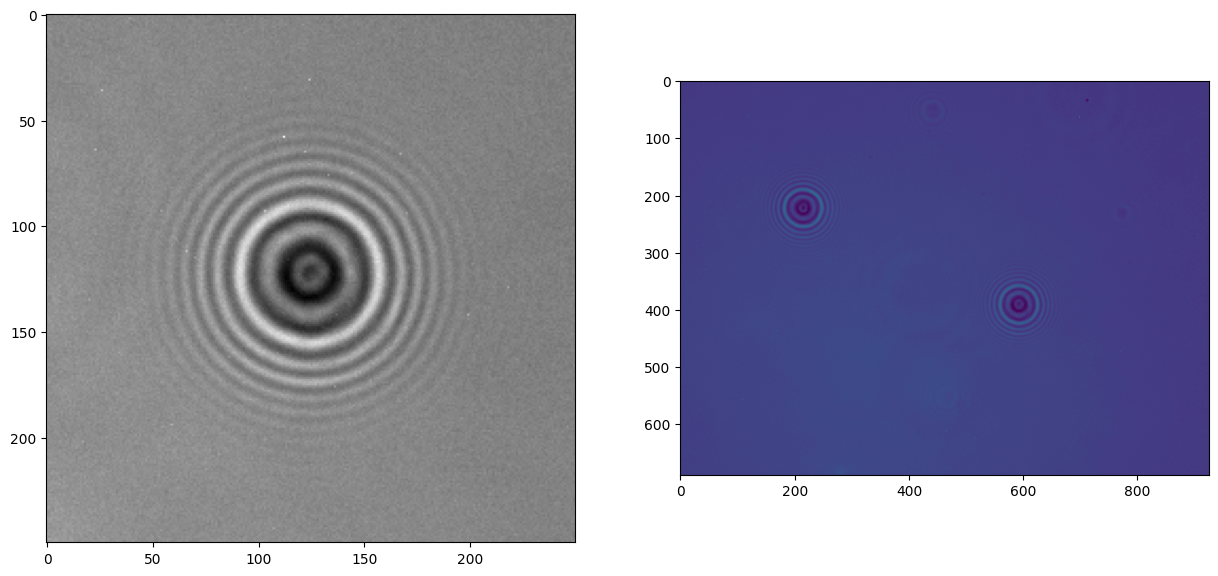

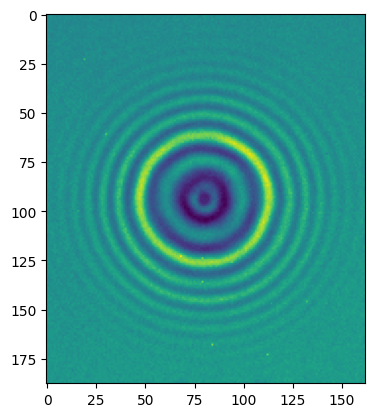

[[79.5      94.5      53.633923]
 [79.5      94.5      43.3317  ]
 [79.5      94.5      32.840874]
 [79.5      94.5      22.756325]
 [79.5      94.5      12.742038]]
80


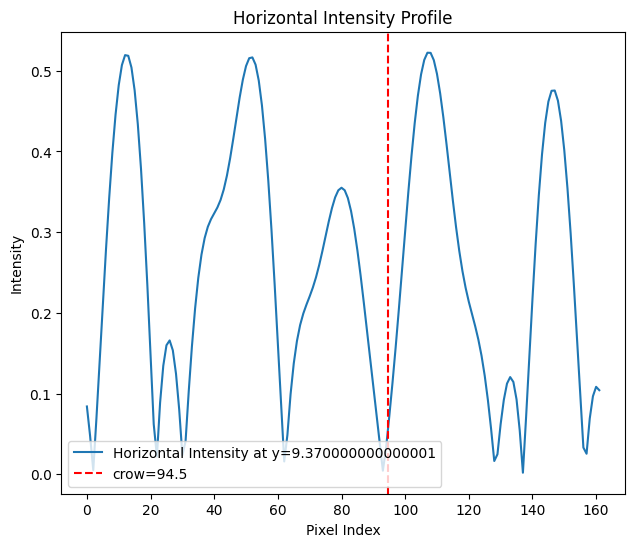

cannot access local variable 'rl_x' where it is not associated with a value


In [286]:
filters = [[3,7]]
for filter in filters:
    test='009'
    input_path='../../Tiffs_Validation'
    # input_tiff=f'../../Test_Large{test}.tif'
    input_tiff=f'../../Video{test}.tif'
    r_in = filter[0]
    r_out = filter[1]
    ring_index = 1
    # brightness=image_background_brightness(get_first_png(input_tiff, input_path))
    params={
        'test_number':test,
        'r_in':r_in,
        'r_out':r_out,
        'ring_index':ring_index,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'../../Results_Validation/Video{test}',
        'output_path':f'../../Results_Validation/Video{test}/cropped_object_2',
        'result_folder' : f"../../Results_Validation/{test}_obj2/" + Path(input_tiff).stem + f"_Results_bw",
        'excel_path' : f'../ExcelsTesting/Video{test}_hough_cropped_obj_2_test.xlsx'
    }
    try:
        ring_search(**params)
    except Exception as e:
        print(e)
        continue
    # ring_search(**params)

In [284]:
# filters = [[3,7]]
# for filter in filters:
#     test='005'
#     input_path='../../Tiffs_Validation'
#     # input_tiff=f'../../Test_Large{test}.tif'
#     input_tiff=f'../../Video{test}.tif'
#     r_in = filter[0]
#     r_out = filter[1]
#     ring_index = 1
#     # brightness=image_background_brightness(get_first_png(input_tiff, input_path))
#     params={
#         'test_number':test,
#         'r_in':r_in,
#         'r_out':r_out,
#         'ring_index':ring_index,
#         'allowed_change':1,
#         'input_path':input_path,
#         'input_tiff':input_tiff,
#         'output_base_path':f'../../Results_Validation/Video{test}',
#         'output_path':f'../../Results_Validation/Video{test}/cropped_object_3',
#         'result_folder' : f"../../Results_Validation/{test}_obj3/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}",
#         'excel_path' : f'../ExcelsTesting/Video{test}_hough_cropped_obj_3.xlsx'
#     }
#     try:
#         ring_search(**params)
#     except Exception as e:
#         print(e)
#         continue
#     # ring_search(**params)